# Data Analysis

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GDELT-Data-Analysis") \
    .getOrCreate()


In [3]:
INPUT_FOLDER = "final_dataset_parquet"

In [4]:
df_final = spark.read.parquet(INPUT_FOLDER)
df_final.show(10,truncate=False,vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Cameo                 | REJECT                                                                                                                                                                                                                    
 Cameo_full            | Reject proposal to meet, discuss, or negotiate                                                                                                                                                                            
 GLOBALEVENTID         | 1144737987                                                                                                                                                                                                                
 SQLDATE               |

Using @Taher daily count to show first the event count through time, we can have a look at what the data is distributed over time :

       SQLDATE  event_count
17  2023-10-18        63522
9   2023-10-10        61745
12  2023-10-13        61401
11  2023-10-12        59343
10  2023-10-11        59089


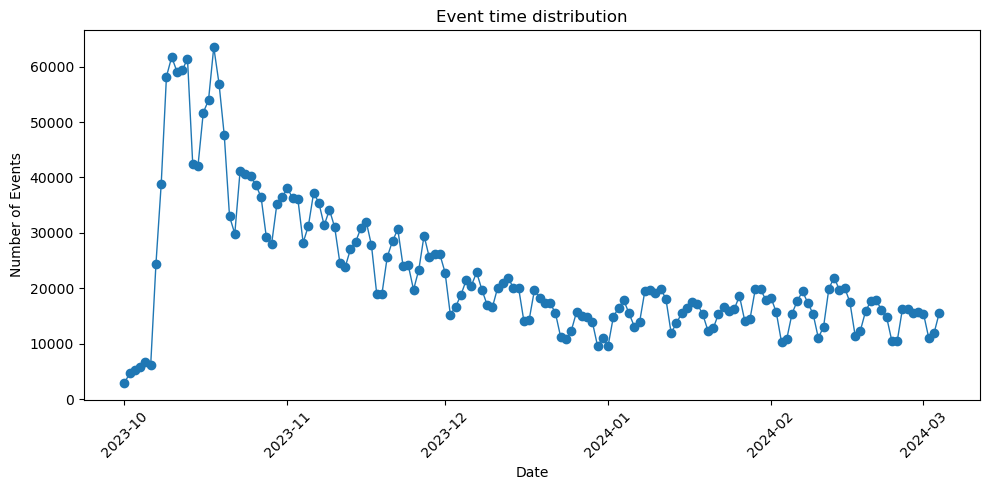

DataFrame[Cameo: string, Cameo_full: string, GLOBALEVENTID: string, SQLDATE: date, Actor1Name: string, Actor1Geo_FullName: string, Actor2Name: string, Actor2Geo_FullName: string, IsRootEvent: string, EventCode: string, EventBaseCode: string, QuadClass: string, GoldsteinScale: double, NumMentions: int, NumSources: int, NumArticles: int, AvgTone: double, ActionGeo_Type: string, ActionGeo_FullName: string, ActionGeo_CountryCode: string, SOURCEURL: string, domain_name: string, news_source_country: string, region: string]

In [94]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, count, sum as _sum

start_date ="2023-10-01"
end_date = "2024-03-31"
fig_name = "figures/01_daily_event_count.png"
title = "Event time distribution"
def PlotEventCoundRange(start_date,end_date,title,fig_name):
    # 1) Aggregate per day
    df_filtered = df_final.filter(
        (col("SQLDATE") >= start_date ) &
        (col("SQLDATE") <= end_date )
    )
    
    daily_counts = (
        df_filtered
          .groupBy("SQLDATE")
          .agg(count("*").alias("event_count"))
          .orderBy("SQLDATE")
    )
    
    # 2) Convert to pandas
    pdf = daily_counts.toPandas()
    print(pdf.sort_values(by="event_count", ascending=False).head(5))
    
    # 3) Plot & save
    plt.figure(figsize=(10, 5))
    plt.plot(pdf["SQLDATE"], pdf["event_count"], marker="o", linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Number of Events")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_name, dpi=300)
    plt.close()

    return df_filtered

PlotEventCoundRange(start_date,end_date,title,fig_name)

It would be interesting to see data from some time before when the conflict didn't reach the international media coverage. But we can see how on this date, the numbers escalated greatly, just to later on lose momentum.

### 0.Question How is the count distribution around certain known events ? 

Let's find some list of events that has happened of the during the conflict.

* The 7th of October the conflict started the exponential escalation with the attack of Hamas over Israel and the retaliation of Israel bombing Gaza
* [The 16th of October Israeli Airstrikes had killed 2,750 people, including more than 700 children](https://www.reuters.com/world/middle-east/gaza-people-resort-drinking-salty-water-garbage-piles-up-2023-10-16/).
* [ 17th of October Al Ahli hospital in Gaza was bombed](https://www.hrw.org/news/2023/11/26/gaza-findings-october-17-al-ahli-hospital-explosion)
* [The 22th of November Israel agrees to a ceasefire](https://www.aljazeera.com/news/2023/11/22/israel-agrees-to-ceasefire-deal-paving-way-for-some-captives-release)
* [The 1st of December Israel breaks truce by bombing and killing 109 people](https://edition.cnn.com/middleeast/live-news/israel-hamas-war-gaza-news-12-1-23#h_c60b80360a70f05957f61a4329819b4d)
* [The 2nd of February airstrikes led again hospital being colapsed in Gaza](https://www.aljazeera.com/news/liveblog/2024/2/5/israels-war-on-gaza-live-israeli-strikes-level-homes-in-deir-el-balah?update=2678954)

Let's see with a 5 day range the event counts over these days

In [12]:
from datetime import date, timedelta, datetime

In [87]:
date_0710 = "2023-10-07"
date_1610 = "2023-10-16"
date_2211 = "2023-11-22"
date_0112 = "2023-12-01"
date_0202 = "2024-02-02"
date_close = "2024-02-28"

      SQLDATE  event_count
1  2023-11-30        26143
0  2023-11-29        26132
2  2023-12-01        22828
5  2023-12-04        18747
4  2023-12-03        16639


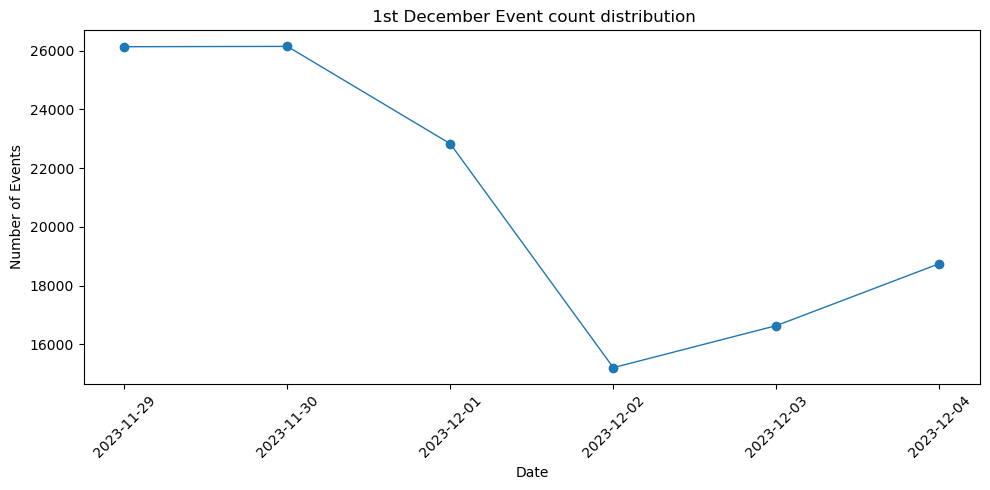

In [96]:
title = " 1st December Event count distribution"
fig_name = "figures/01_2_daily_event_count.png"

start_date = datetime.strptime(date_0112, '%Y-%m-%d').date()
end_date = start_date  + timedelta(days=3)
start_date = start_date - timedelta(days=2)
df_1December = PlotEventCoundRange(start_date,end_date,title,fig_name)

      SQLDATE  event_count
5  2023-10-10        61745
4  2023-10-09        58212
3  2023-10-08        38784
2  2023-10-07        24346
0  2023-10-05         6747


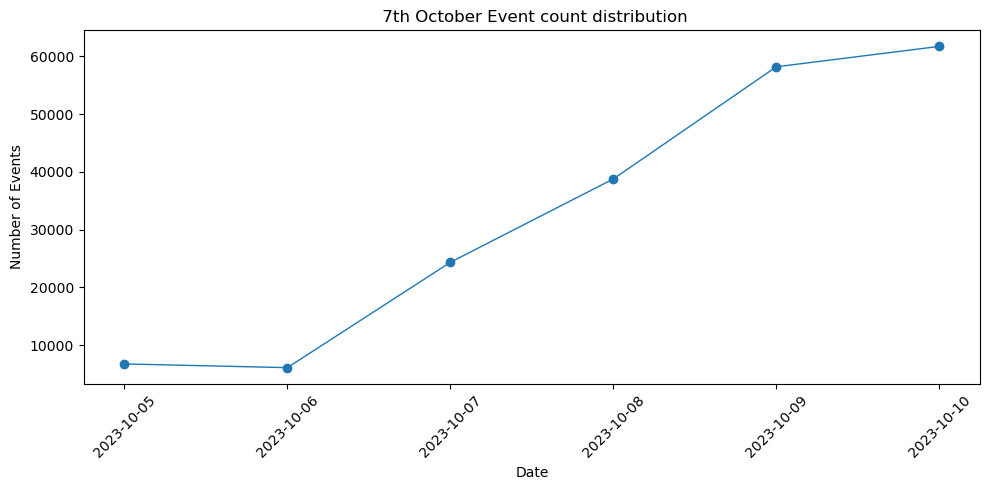

In [97]:
title = " 7th October Event count distribution"
fig_name = "figures/01_3_daily_event_count.png"

start_date = datetime.strptime(date_0710, '%Y-%m-%d').date()
end_date = start_date  + timedelta(days=3)
start_date = start_date - timedelta(days=2)
df_7october = PlotEventCoundRange(start_date,end_date,title,fig_name)

## 1.Question : What type of media can we see in GDELT?

From [pressgazette.co.uk](https://pressgazette.co.uk/media-audience-and-business-data/media_metrics/most-popular-websites-news-world-monthly-2/)  we have obtained this image of the fastest growing website in english. ( from 2024 to 2025)

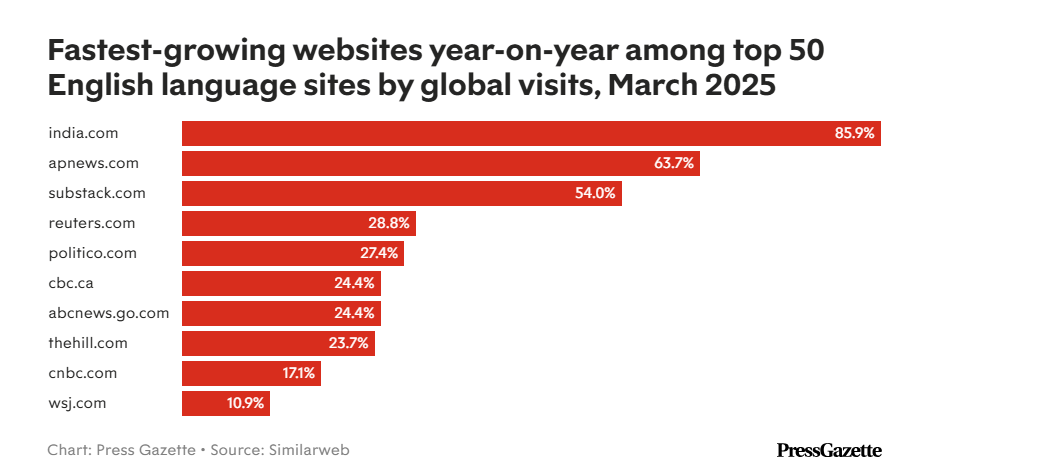 
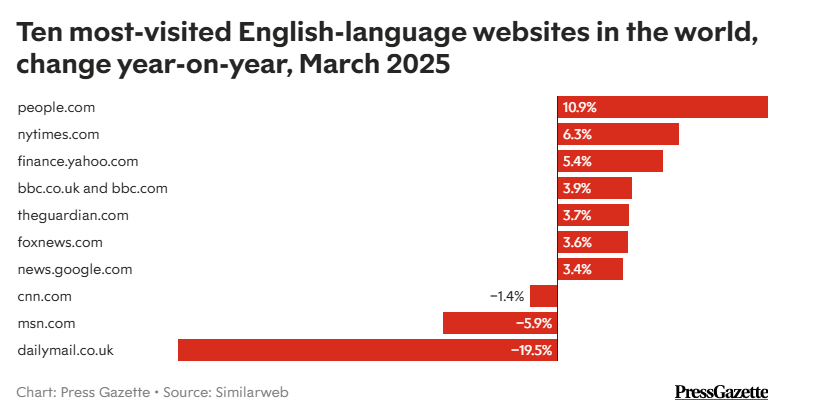

So let's see how many of these websites are contained in our GDELT dataset.

In [21]:
from pyspark.sql import functions as F

In [149]:
most_visited_media = ["people.com","nytimes.com","finance.yahoo.com","yahoo.com","bbc.co.uk","bbc.com","theguardian.com","foxnews.com","news.google.com","cnn.com","msn.com","daily.co.ul"]

df_visited = df_filtered.filter(F.col("domain_name").isin(most_visited_media))
df_visited_domain = df_visited.groupBy("domain_name","region").agg(F.count("*").alias("count"))

df_visited_domain.show()


+-----------------+------+-----+
|      domain_name|region|count|
+-----------------+------+-----+
|          cnn.com|   USA|23198|
|      nytimes.com|   USA|17447|
|finance.yahoo.com|   USA| 2306|
|  theguardian.com|Europe|24615|
|        yahoo.com|   USA| 8390|
|        bbc.co.uk|Europe| 6661|
|          bbc.com|Europe| 4720|
|      foxnews.com|   USA|18951|
|       people.com|   USA|  221|
+-----------------+------+-----+



In [148]:
fastest_growing_media = ["india.com","apnews.com","substack.com","reuters.com","politico.com","cbc.ca","abcnews.go","thehill.com","cnbc.com","wsj.com"]

df_growing = df_filtered.filter(F.col("domain_name").isin(fastest_growing_media))
df_popular= df_growing.groupBy("domain_name","region").agg(F.count("*").alias("count"))

df_popular.show()


+------------+------+-----+
| domain_name|region|count|
+------------+------+-----+
|    cnbc.com|   USA| 2617|
|      cbc.ca|   USA|12117|
|     wsj.com|   USA| 1365|
| thehill.com|   USA|  175|
| reuters.com|Europe| 4646|
|  apnews.com|   USA| 2146|
|politico.com|   USA| 4577|
|   india.com| other| 1444|
+------------+------+-----+



In [146]:
for media in most_visited_media:
    df_popular = df_filtered.filter(F.col("domain_name") == (media))
    print(f"Results for {media} is {df_popular.count()}")
    

Results for people.com is 221
Results for nytimes.com is 17447
Results for finance.yahoo.com is 2306
Results for yahoo.com is 8390
Results for bbc.co.uk is 6661
Results for bbc.com is 4720
Results for theguardian.com is 24615
Results for foxnews.com is 18951
Results for news.google.com is 0
Results for cnn.com is 23198
Results for msn.com is 0
Results for daily.co.ul is 0


In [47]:
for media in fastest_growing_media:
    df_popular = df_filtered.filter(F.col("domain_name") == (media))
    print(f"Results for {media} is {df_popular.count()}")
    

Results for india.com is 1444
Results for apnews.com is 2146
Results for substack.com is 0
Results for reuters.com is 4646
Results for politico.com is 4577
Results for cbc.ca is 12117
Results for abcnews.go is 0
Results for thehill.com is 175
Results for cnbc.com is 2617
Results for wsj.com is 1365


With these two lines, we confirm which are the most popular and which don't appear on GDELT.

What about some other international media? In Spain for example, one of the main news media is "ElPais". Let's see how many counts do we get from that! Note: checking, there is only english.elpais.com

In [48]:
df_filtered.filter(F.col("domain_name").rlike("english.elpais.com")).show(1,vertical=True)

-RECORD 0-------------------------------------
 Cameo                 | CONSULT              
 Cameo_full            | Make a visit         
 GLOBALEVENTID         | 1144908528           
 SQLDATE               | 2023-12-07           
 Actor1Name            | NaN                  
 Actor1Geo_FullName    | NaN                  
 Actor2Name            | RESIDENTS            
 Actor2Geo_FullName    | Rahat, HaDarom, I... 
 IsRootEvent           | 0                    
 EventCode             | 042                  
 EventBaseCode         | 042                  
 QuadClass             | 1                    
 GoldsteinScale        | 1.9                  
 NumMentions           | 13                   
 NumSources            | 1                    
 NumArticles           | 10                   
 AvgTone               | -1.42247510668564    
 ActionGeo_Type        | 4                    
 ActionGeo_FullName    | Rahat, HaDarom, I... 
 ActionGeo_CountryCode | IS                   
 SOURCEURL   

In [49]:
df_popular = df_popular_domain.filter(F.col("domain_name").isin("english.elpais.com"))

df_popular.show()

+------------------+------+-----+
|       domain_name|region|count|
+------------------+------+-----+
|english.elpais.com|Europe| 6728|
+------------------+------+-----+



### 1.2 Question: Top media from GDELT?

In [57]:
df_popular_domain.orderBy(F.desc("count")).show(20)

+--------------------+-----------+-----+
|         domain_name|     region|count|
+--------------------+-----------+-----+
|      news.yahoo.com|        USA|99768|
|           jpost.com|Middle East|58475|
|  globalsecurity.org|Middle East|45840|
|     dailymail.co.uk|     Europe|43811|
|israelnationalnew...|Middle East|36230|
|          presstv.ir|Middle East|32542|
|      al-monitor.com|Middle East|31456|
|       aljazeera.com|Middle East|28863|
|english.ahram.org.eg|Middle East|28032|
|          menafn.com|Middle East|26786|
|clevelandjewishne...|Middle East|26113|
|           aa.com.tr|Middle East|25647|
|     theguardian.com|     Europe|24615|
| thenationalnews.com|Middle East|23999|
|             cnn.com|        USA|23198|
|middleeastmonitor...|Middle East|21778|
|          nypost.com|        USA|20229|
|       firstpost.com|      other|19936|
|   timesofisrael.com|Middle East|19729|
|   middleeasteye.net|Middle East|19361|
+--------------------+-----------+-----+
only showing top

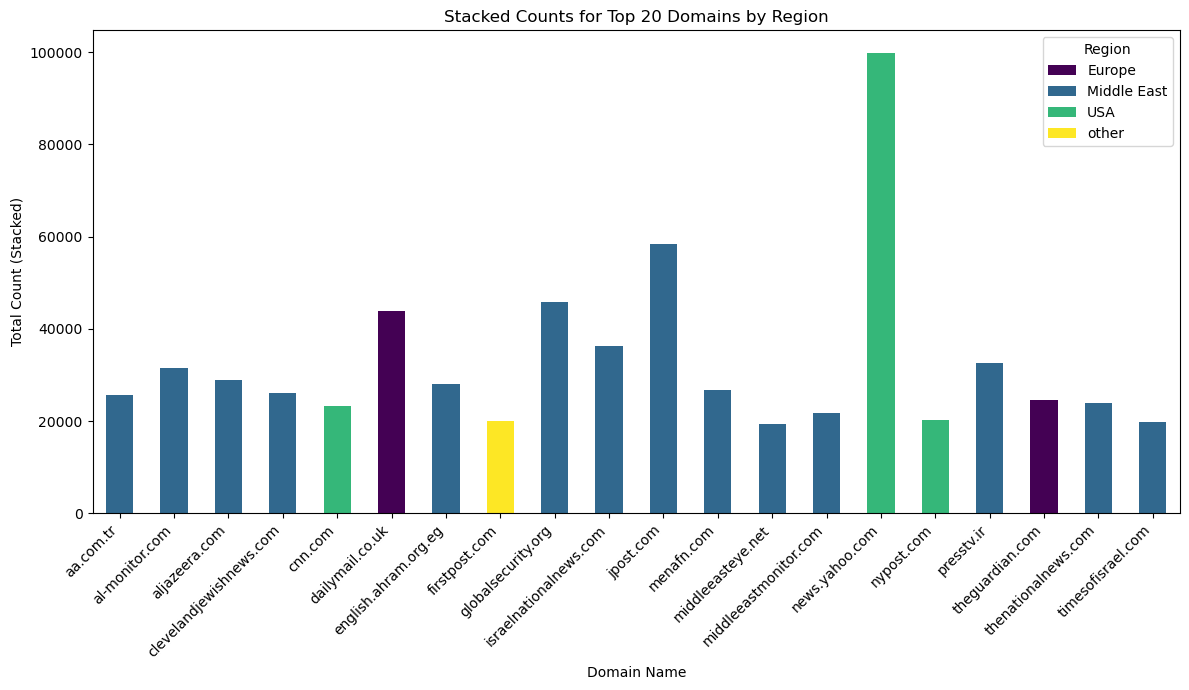

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top = 20

df_top20_domains = df_popular_domain.orderBy(F.desc("count")).limit(top)

pandas_top20_domains = df_top20_domains.toPandas()


pandas_pivot = pandas_top20_domains.pivot_table(index='domain_name', columns='region', values='count', fill_value=0)

# Plot using Pandas built-in plotting (which uses Matplotlib)
ax = pandas_pivot.plot(kind='bar', stacked=True, figsize=(12, 7),
                           colormap='viridis') # Choose a colormap

plt.title(f'Stacked Counts for Top {top} Domains by Region')
plt.xlabel('Domain Name')
plt.ylabel('Total Count (Stacked)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [75]:
print(f"Europe has {df_top20_domains.filter(F.col('region').isin('Europe')).count()} media in the top 20 and {df_popular_domain.filter(F.col('region').isin('Europe')).count()} in total in this dataset."),
print(f"America has has {df_top20_domains.filter(F.col('region').isin('USA')).count()} media in the top 20 and {df_popular_domain.filter(F.col('region').isin('USA')).count()} in total in this dataset."),
print(f"Middle-East has has {df_top20_domains.filter(F.col('region').isin('Middle East')).count()} media in the top 20 and {df_popular_domain.filter(F.col('region').isin('Middle East')).count()} in total in this dataset.")

Europe has 2 media in the top 20 and 1126 in total in this dataset.
America has has 3 media in the top 20 and 4752 in total in this dataset.
Middle-East has has 14 media in the top 20 and 293 in total in this dataset.


## 2 Question : How are the higher event count days reported ? What cameos are shown the most ?

Let's check again the dataframe 

In [89]:
df_final.show(10,truncate=False,vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Cameo                 | REJECT                                                                                                                                                                                                                    
 Cameo_full            | Reject proposal to meet, discuss, or negotiate                                                                                                                                                                            
 GLOBALEVENTID         | 1144737987                                                                                                                                                                                                                
 SQLDATE               |

In [104]:
df_cameo = df_filtered.groupBy("cameo","Actor1Name","Actor1Name","GLOBALEVENTID","SOURCEURL","domain_name","region").agg(F.count("*").alias("count"))
df_cameo.show(10,truncate=False,vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------
 cameo         | CONSULT                                                                                                                                   
 Actor1Name    | PRESIDENT                                                                                                                                 
 Actor1Name    | PRESIDENT                                                                                                                                 
 GLOBALEVENTID | 1144739332                                                                                                                                
 SOURCEURL     | http://jordantimes.com/opinion/michael-jansen/netanyahu-%E2%80%98human-shields%E2%80%99-must-endure-suffering-israel-persistently-pursues 
 domain_name   | jordantimes.com                                

checking some events from GDELT can be complicated. From example, event 1144741218 from exploreiowa is not available.         

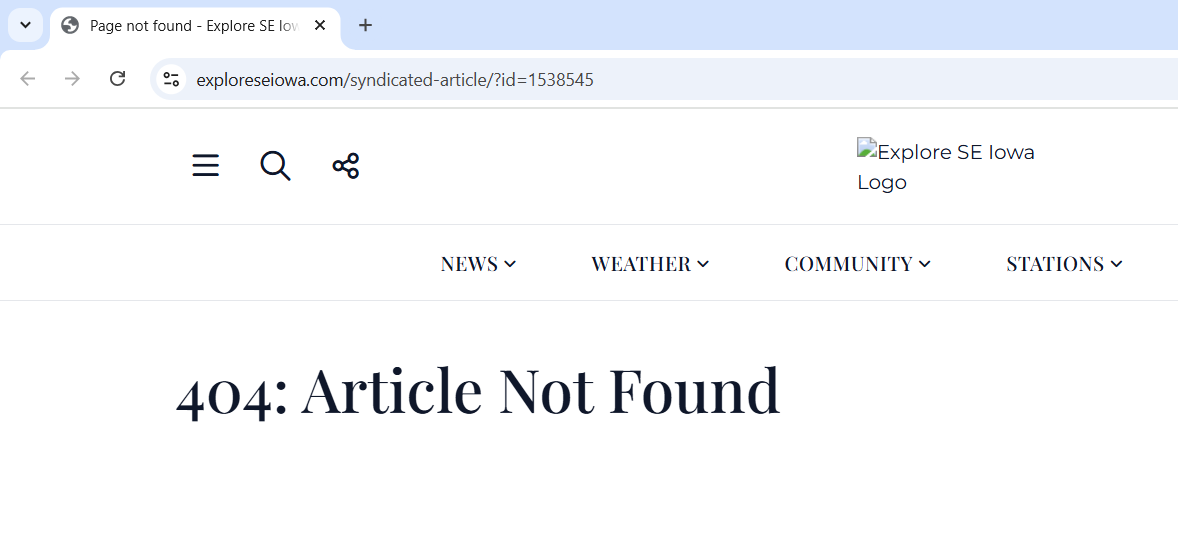  

As we don't get the aggregation done as we have different SourceUrl with different values, let's drop that and re-do the aggregation!

This first is only to see domain. With this, we answer the question :

### 2.1 Question : What cameos do the main domains use ?

In [140]:
df_cameo_domain = df_filtered.groupBy("cameo","domain_name","region").agg(F.count("*").alias("count"))
df_cameo_domain.show(10,truncate=False,vertical=True)

-RECORD 0------------------------------
 cameo       | FIGHT                   
 domain_name | odnako.org              
 region      | other                   
 count       | 340                     
-RECORD 1------------------------------
 cameo       | DISAPPROVE              
 domain_name | nytimes.com             
 region      | USA                     
 count       | 1541                    
-RECORD 2------------------------------
 cameo       | CONSULT                 
 domain_name | clevelandjewishnews.com 
 region      | Middle East             
 count       | 6563                    
-RECORD 3------------------------------
 cameo       | EXHIBIT FORCE POSTURE   
 domain_name | reliefweb.int           
 region      | Middle East             
 count       | 58                      
-RECORD 4------------------------------
 cameo       | APPEAL                  
 domain_name | siasat.com              
 region      | other                   
 count       | 338                     


Let's select the top 20 as we did before

In [141]:
def topN(dataframe,top):
    df_top20_domains = dataframe.orderBy(F.desc("count")).limit(top)
    df_top20_domains.show(truncate=False,vertical=False)
    return df_top20_domains

df_top20_domains = topN(df_cameo_domain,top)

+--------------------------------+-----------------------+-----------+-----+
|cameo                           |domain_name            |region     |count|
+--------------------------------+-----------------------+-----------+-----+
|CONSULT                         |news.yahoo.com         |USA        |20949|
|CONSULT                         |jpost.com              |Middle East|16881|
|MAKE PUBLIC STATEMENT           |news.yahoo.com         |USA        |12229|
|FIGHT                           |news.yahoo.com         |USA        |11985|
|CONSULT                         |al-monitor.com         |Middle East|10056|
|CONSULT                         |dailymail.co.uk        |Europe     |9425 |
|CONSULT                         |globalsecurity.org     |Middle East|8922 |
|CONSULT                         |israelnationalnews.com |Middle East|8625 |
|DISAPPROVE                      |news.yahoo.com         |USA        |8221 |
|FIGHT                           |globalsecurity.org     |Middle East|7800 |

Creating a function so it doesn't take extra space as we will use. Is the same plot function we used before !

In [134]:
def MultiPlot(dataframe,index,columns,values,top,title=None):
    pandas_top20_domains = dataframe.toPandas()
    pandas_pivot = pandas_top20_domains.pivot_table(index=index, columns=columns, values=values, fill_value=0)
    
    # Plot using Pandas built-in plotting (which uses Matplotlib)
    ax = pandas_pivot.plot(kind='bar', stacked=True, figsize=(12, 7),
                               colormap='viridis') # Choose a colormap
    if title:
        plt.title(title)
    else:
        plt.title(f'Stacked Counts for Top {top} {index} by {columns}')
    plt.xlabel('Domain Name')
    plt.ylabel('Total Count (Stacked)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='domain')
    plt.tight_layout()
    plt.show()

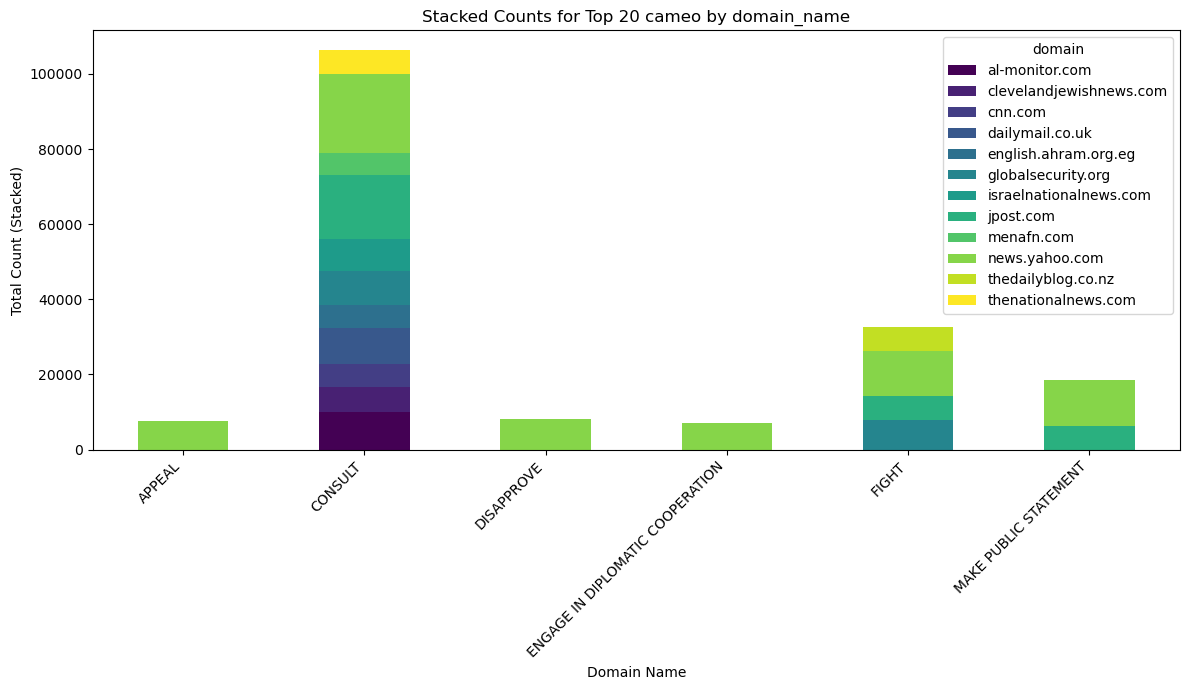

In [120]:
MultiPlot(dataframe=df_top20_domains,index='cameo', columns='domain_name', values='count',top=top)

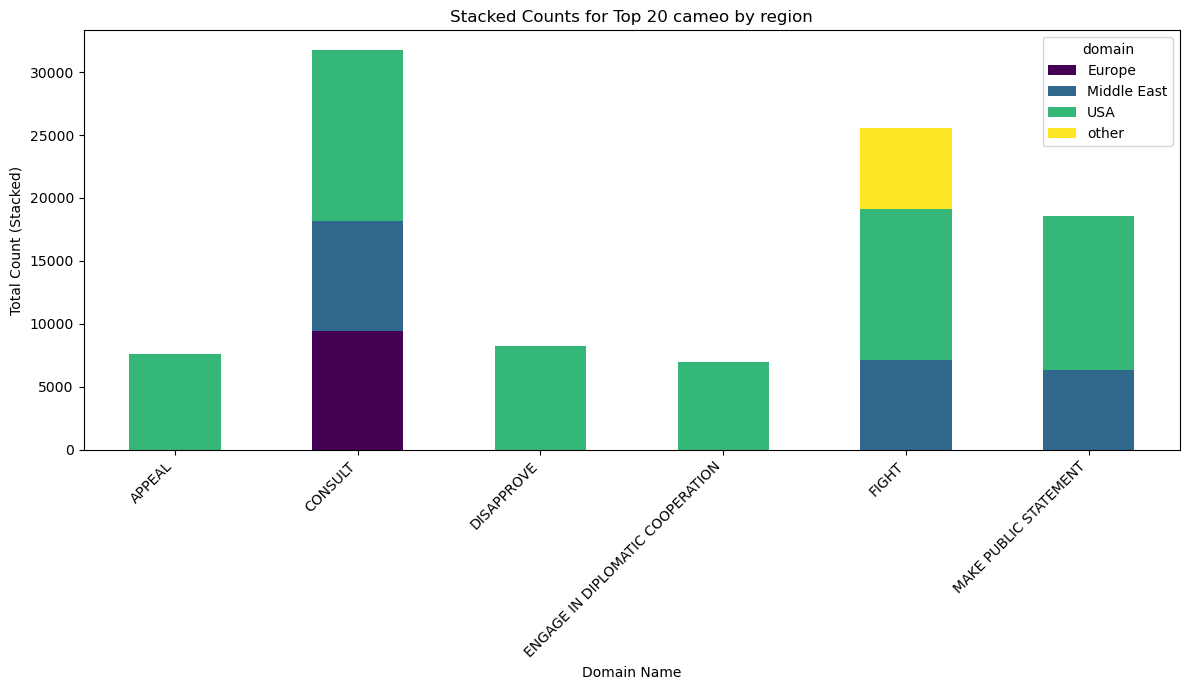

In [118]:
MultiPlot(dataframe=df_top20_domains,index='cameo', columns='region', values='count',top=top)

### 2.3 Question : How do cameos vary depending on the days of the events ?

Let's prepare cameo domain with the two dates we checked before.

In [137]:
df_cameo_domain_7 = df_7october.groupBy("cameo","domain_name","region").agg(F.count("*").alias("count"))
df_cameo_domain_7.show(10,truncate=False,vertical=False)

+------------------------------+-------------------+-----------+-----+
|cameo                         |domain_name        |region     |count|
+------------------------------+-------------------+-----------+-----+
|DISAPPROVE                    |nytimes.com        |USA        |77   |
|FIGHT                         |aol.com            |USA        |66   |
|PROVIDE AID                   |ici.radio-canada.ca|USA        |2    |
|APPEAL                        |theday.com         |USA        |4    |
|EXPRESS INTENT TO COOPERATE   |bocanewsnow.com    |USA        |4    |
|MAKE PUBLIC STATEMENT         |wprl.org           |USA        |10   |
|INVESTIGATE                   |taiwansun.com      |other      |3    |
|ENGAGE IN MATERIAL COOPERATION|algemeiner.com     |Middle East|10   |
|FIGHT                         |reuters.com        |Europe     |70   |
|EXPRESS INTENT TO COOPERATE   |bostonherald.com   |USA        |15   |
+------------------------------+-------------------+-----------+-----+
only s

In [138]:
df_top20_domains_7 = topN(df_cameo_domain_7,top)

+--------------------------------+-----------------+-----------+-----+
|cameo                           |domain_name      |region     |count|
+--------------------------------+-----------------+-----------+-----+
|CONSULT                         |news.yahoo.com   |USA        |953  |
|FIGHT                           |news.yahoo.com   |USA        |863  |
|FIGHT                           |dailymail.co.uk  |Europe     |840  |
|CONSULT                         |timesofisrael.com|Middle East|713  |
|CONSULT                         |dailymail.co.uk  |Europe     |700  |
|MAKE PUBLIC STATEMENT           |news.yahoo.com   |USA        |671  |
|FIGHT                           |timesofisrael.com|Middle East|595  |
|ENGAGE IN DIPLOMATIC COOPERATION|news.yahoo.com   |USA        |491  |
|DISAPPROVE                      |news.yahoo.com   |USA        |454  |
|CONSULT                         |al-monitor.com   |Middle East|449  |
|FIGHT                           |aljazeerah.info  |Middle East|436  |
|MAKE 

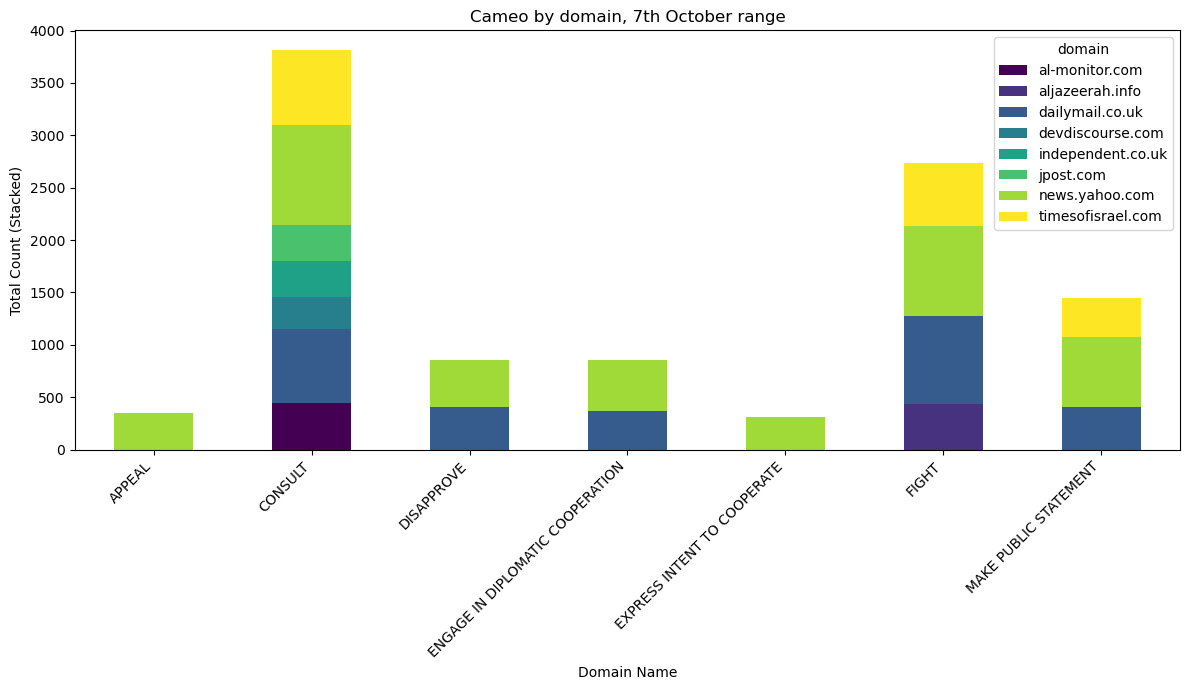

In [142]:
MultiPlot(dataframe=df_top20_domains_7,index='cameo', columns='domain_name', values='count',top=top, title="Cameo by domain, 7th October range")

Comparing side by side :

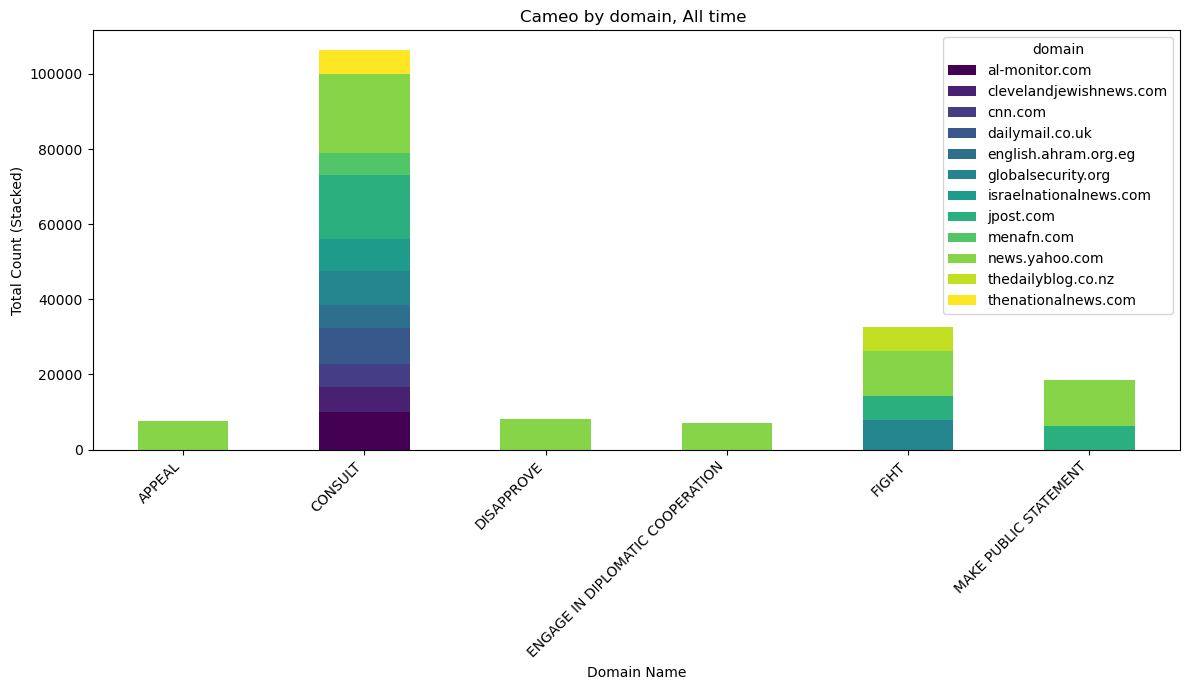

In [143]:
MultiPlot(dataframe=df_top20_domains,index='cameo', columns='domain_name', values='count',top=top, title="Cameo by domain, All time ")

NOTE : There is a problem here about how the data is getting grouped in this data. I would find more benefitial selecting distinct URLs and see the CAMEOS for this specific side.

### How are the cameo code representation for the fastest growing media and the most visited media, which are the most influencial ?

In [151]:
df_cameo_domain = df_growing.groupBy("cameo","domain_name","region").agg(F.count("*").alias("count"))
df_cameo_domain.show(10,truncate=False,vertical=True)

-RECORD 0---------------------------------------
 cameo       | FIGHT                            
 domain_name | reuters.com                      
 region      | Europe                           
 count       | 591                              
-RECORD 1---------------------------------------
 cameo       | APPEAL                           
 domain_name | apnews.com                       
 region      | USA                              
 count       | 121                              
-RECORD 2---------------------------------------
 cameo       | REDUCE RELATIONS                 
 domain_name | politico.com                     
 region      | USA                              
 count       | 58                               
-RECORD 3---------------------------------------
 cameo       | REJECT                           
 domain_name | wsj.com                          
 region      | USA                              
 count       | 21                               
-RECORD 4-----------

In [159]:
len(most_visited_media),most_visited_media

(12,
 ['people.com',
  'nytimes.com',
  'finance.yahoo.com',
  'yahoo.com',
  'bbc.co.uk',
  'bbc.com',
  'theguardian.com',
  'foxnews.com',
  'news.google.com',
  'cnn.com',
  'msn.com',
  'daily.co.ul'])

In [158]:
len(fastest_growing_media),fastest_growing_media

(10,
 ['india.com',
  'apnews.com',
  'substack.com',
  'reuters.com',
  'politico.com',
  'cbc.ca',
  'abcnews.go',
  'thehill.com',
  'cnbc.com',
  'wsj.com'])

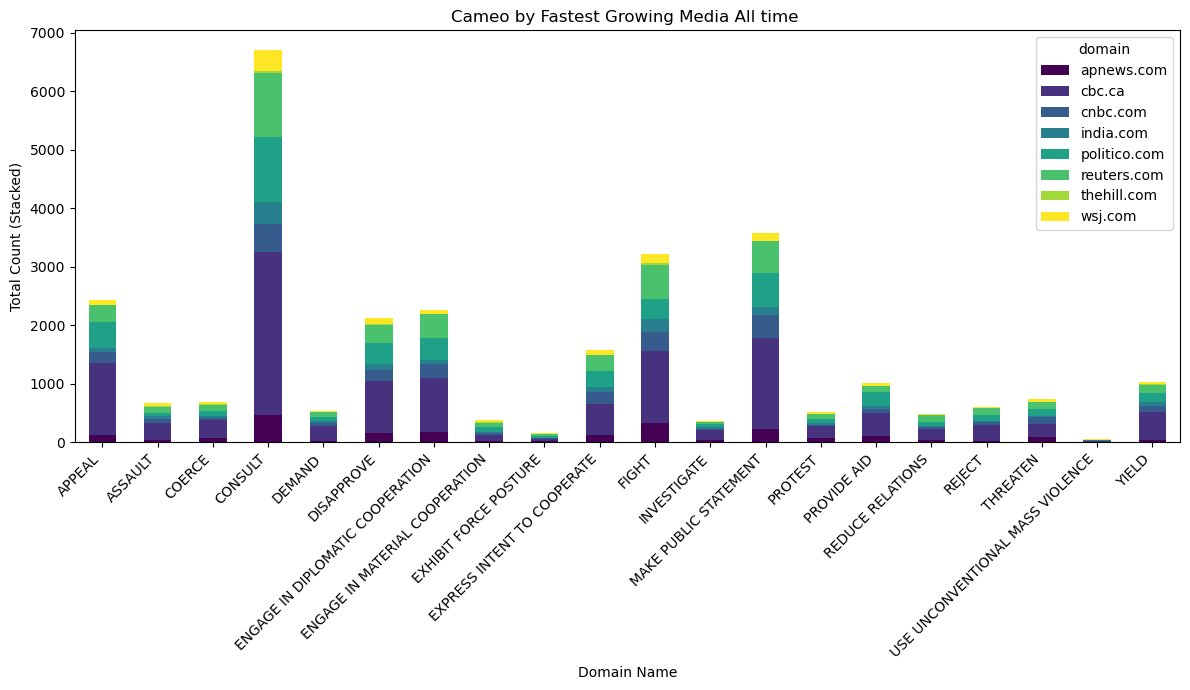

In [152]:
MultiPlot(dataframe=df_cameo_domain,index='cameo', columns='domain_name', values='count',top=top, title="Cameo by Fastest Growing Media All time ")

### 2.X Question : How about the actors? what information do we get from them in GDELT ?

TO BE CONTINUED ...

In [126]:
df_cameo_large = df_filtered.groupBy("cameo","Actor1Name","Actor1Name","domain_name","region").agg(F.count("*").alias("count"))
df_cameo.show(10,truncate=False,vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------
 cameo         | CONSULT                                                                                                                                   
 Actor1Name    | PRESIDENT                                                                                                                                 
 Actor1Name    | PRESIDENT                                                                                                                                 
 GLOBALEVENTID | 1144739332                                                                                                                                
 SOURCEURL     | http://jordantimes.com/opinion/michael-jansen/netanyahu-%E2%80%98human-shields%E2%80%99-must-endure-suffering-israel-persistently-pursues 
 domain_name   | jordantimes.com                                